<a href="https://colab.research.google.com/github/withjungjh/My-Neuromatch-Academy/blob/main/EEG%20eye%20state%20ML%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2018250168_정진환_프로젝트

# EEG eye state



## Abstract
EEG에서 주요하게 발생하는 noise는 눈을 깜빡이는 것이 원인이 된다. Signal to noise ratio를 높이기 위해서 언제 눈을 깜빡였는지 확인하는 것은 EEG data를 다를 때 중요한 문제가 된다. 이 보고서에서는 EEG eye state data에서 Decision Tree, Perceptron, Multi-Layered Perceptron(MLP), Random Forest 등의 머신러닝 알고리즘과 feature selection을 이용하여 눈을 감았는지 떴는지 확인하는 모델을 만들고 각각의 성능을 비교하였다. 이러한 과정을 통해 0.91의 accuracy를 가진 non-feature-selection Random Forest 모델을 얻었다. 

## Introduction

Electroencephalography(EEG)는 뇌의 활동을 전기장 변화를 이용하여 관찰하는 방법으로 ground potential과 뇌의 특정 영역에 부착한 전극에서의 potential 차이를 계산하여 비침습적인 방법으로 뇌의 활동을 측정할 수 있다. EEG는 뉴런 집단의 활동을 두피 바깥쪽에서 측정하기 때문에 뇌 안에서 발생한 신호와 노이즈를 구분하는 것이 중요하다. 여기에서 상당히 크게 영향을 미칠 수 있는 노이즈 중 하나는 눈을 깜빡이는 행동이다. 따라서 이 보고서에서는 `EEG eye state'("https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff") 데이터를 가져와 EEG 신호만으로 눈을 감았었는지 확인할 수 있는 모델을 만드려고 한다. 

### Data Descirption
이 데이터는 Emotiv EEG Neuroheadset을 가지고 117초 동안 측정한 continuous EEG signal이다. 이 데이터에서는 이 신호를 각 위치에 따라서 다음과 같은 표기법으로 표현하였다.: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4. EEG 측정과 동시에 눈의 상태를 관찰하는 카메라를 통해 눈을 떴는지 감았는지를 측정하여 'eyeDetection' feature을 추가하였다. 'eyeDetection' feature은 눈이 뜬 상태를 '0', 눈을 감은 상태를 '1'로 표현한 binary categorical feature이다. 데이터의 instance는 시간 순으로 정렬되어 있다. (Retrieved from https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State)

In [ ]:
#@ title importing module
# basic
import numpy as np
import pandas as pd
# for load arff file
from scipy.io.arff import loadarff
from io import StringIO, BytesIO
import urllib.request
# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Cross validation and feature selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
# ML algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
# Evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff"
resp = urllib.request.urlopen(url)
data, meta = loadarff(StringIO(resp.read().decode('utf-8')))

names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4", "eyeDetection"]

df = pd.DataFrame(data)
df.columns = names

for c in df.columns:
  if df[c].dtype == "object":
    df[c] = df[c].str.decode("UTF-8")

df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [ ]:
df.shape

(14980, 15)

이 데이터는 15개의 feature과 14980개의 instance로 이루어져 있다. 'eyeDetection' column을 제외하면 모두 실수로 이루어진 데이터이다. 

In [ ]:
# split feature data and label data
X = df.drop(columns="eyeDetection")
y = df["eyeDetection"].astype("int") # int로 바꾸지 않으면 RandomForest에서 unknown label 문제 발생


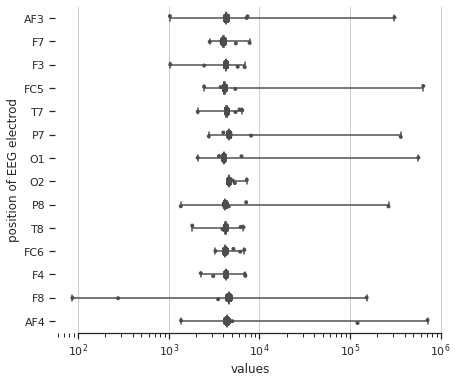

In [ ]:
# feature data description


X2 = pd.melt(X, var_name = "position", value_name="values")
X2.head()

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7,6))
ax.set_xscale("log")

sns.boxplot(x="values", y = "position", data = X2, whis=[0,100], width=0.5, palette="vlag")

sns.stripplot(x="values", y = "position", data = X2,size = 4, color=".3", linewidth=0)

ax.xaxis.grid(True)
ax.set(ylabel="position of EEG electrod")
sns.despine(trim=True, left=True)



위 그래프를 보면 각 측정 부위 마다 몇 개의 outlier가 존재하는 것을 볼 수 있는데, 그렇게 많지는 않기 때문에 위 값들을 분석할 때 제거하지는 않고 진행하였다. log scale이라서 각 EEG electrode 별로 큰 차이가 없어보이기는 하지만 O2, F8 등은 다른 영역들과 분포에서 차이를 보이는 것을 확인할 수 있다.

## Method

### Data preporcessing
- not available value는 없었고 특이점들이 어떤 역할을 할 수도 있을 것이라 판단되어 없애지 않았다. 





In [ ]:
df.isna().sum() # na 없음

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

### Baseline
 Baseline 으로 Zero Rule을 이용하였다. One Rule을 baseline으로 이용하기도 하지만 여기에서는 feature value가 모두 numeric value를 가지고 있다보니 rule을 만들기 위해서는 기준점이 필요한데, 그 기준점을 설정하는 것이 쉽지 않아 One Rule을 Baseline으로 설정하지는 않았다. Zero Rule은 label된 값들의 비율만 가지고 판단을 했을 때 어느 정도의 정확도를 가지는지 보여주는 가장 기초적인 방식이다. 그래서 다른 모델을 보기에 앞서서 baseline을 설정할 때 보는 매우 간단한 모델이다. 하지만 class의 비율을 본다는 점에서 class imbalance가 얼마나 심한지 보여주는 지표이기도 하다. 

eyeDetection이 label feature이기 때문에 이를 가지고 각 class의 개수를 구하고 accuracy를 구하면 다음과 같이 나온다. 

In [ ]:
# baseline 
# ML algorithm baseline : ZeroR

df["eyeDetection"].value_counts(sort=True)

0    8257
1    6723
Name: eyeDetection, dtype: int64

In [ ]:
print('Accuracy(eye Detection = 1)', 8257/(8257+6723) )

Accuracy(eye Detection = 1) 0.5512016021361815


### Feature Selection
model을 이용한 embeded method를 이용하였다. noise feature을 추가한 뒤 RandomForest를 이용하여 좋은 성능을 보여주는 feature을 골라내는 방식으로 feature selection을 진행했다. 14개의 orginal feature에 6개의 noise feature을 추가하고 평가 후에 10개의 feature만 골랐는데, 10개 모두 original feature에 속해있는 feature였다.

각 Machine learning algorithm 별로 feature selection을 진행한 것과 그렇지 않은 것을 비교하기 위해서 각 모델을 학습시킬 때 feature selection을 진행한 것과 그렇지 않고 학습한 것을 모두 진행하였다. 



In [ ]:
# 고정된 난수를 발생시킵니다.
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(X), 6))
# 데이터에 noise feature을 추가합니다. 처음 14개는 original feature이고 다음 6개는 noise feature입니다.
X_w_noise = np.hstack([X, noise])

In [ ]:
# training dataset test dataset split for feature selection
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_w_noise, y, random_state=42, test_size=0.5)

# training set and test set without feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

In [ ]:
# model-based feature selection 1
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median") 


In [ ]:
select.fit(X_train_n, y_train_n)
X_train_l1 = select.transform(X_train_n) # selected feature X_train_l1
print("X_train.shape:", X_train_n.shape)
print("X_train_l1.shape:", X_train_l1.shape)

X_train.shape: (7490, 20)
X_train_l1.shape: (7490, 10)


Text(0.5, 0, 'featue number')

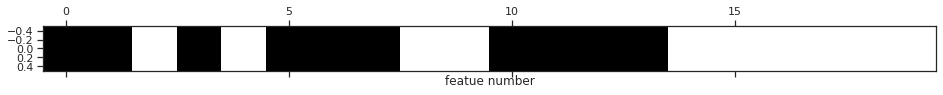

In [ ]:
# selected feature
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("featue number")

In [ ]:
# 수동으로 feature selected data set 만들기 
# 위에서 만든 X_train_l1을 썼을 때 에러와 함께 모델이 제대로 학습되지 않는 경우 발생
X_train_l1 = X_train
for i in range(len(X_train_l1.columns)):
  if mask[i] == False:
    col = X_train_l1.columns[i]
    X_train_l1 = X_train_l1.drop(columns=col)

X_test_l1 = X_test
for i in range(len(X_test_l1.columns)):
  if mask[i] == False:
    col = X_test_l1.columns[i]
    X_test_l1 = X_test_l1.drop(columns=col)
print(X_test_l1.columns)
print(len(X_test_l1.columns))

Index(['AF3', 'F7', 'FC5', 'T7', 'O1', 'O2', 'P8', 'T8', 'F4', 'AF4'], dtype='object')
10


### Algorithm and Parameter Optimization with Cross Validation
Machine learning algorith으로는 
Decision Tree(DT), Perceptron, Multi-layered Perceptron, Random Forest를 사용하였다. Stratified 10-fold cross validation을 이용하여 parameter의 변경에 따른 성능을 validation test를 통해 확인하였다. 그리고 가장 좋은 성능을 보여준 parameter 값으로 model을 만들었다.

이러한 과정을 각 모델별로 조정할 parameter를 지정해서 만든 함수 `KFoldCV_optimal_Finder_DT`, `KFoldCV_optimal_Finder_P`, `KFoldCV_optimal_Finder_MLP`, `KFoldCV_optimal_Finder_RF`를 이용하여 진행하였다.

#### Decision Tree

Decision Tree Classifier에서는 `max_leaf_node` parameter를 조정하며 어느 지점이 가장 괜찮은 성능을 낼 지 cross validation을 통해 확인하였다. `max_leaf_node`는 tree의 끝단에 있는 node의 개수를 제한함으로서 overfitting을 방지하는 효과를 가진 것으로 알려져 있다. 여기에서는 100에서 1000으로 가며 어떻게 validation test score의 평균값이 변하는지 확인하였다. 

In [ ]:
def KFoldCV_optimal_Finder_DT(list_num, X_train, y_train):
  list = list_num
  score = []

  skf = StratifiedKFold(n_splits=10)
  val_accuracy = np.array([])

  for k in list:
    M = DecisionTreeClassifier(max_leaf_nodes=k, random_state=42)
    for train_index, val_index in skf.split(X_train, y_train):
      X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
      y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
      M.fit(X_train_cv, y_train_cv)
      val_accuracy = np.append(val_accuracy, M.score(X_val_cv, y_val_cv))
    
    score.append(val_accuracy.mean())

  print('most optimal parameter value:', list[np.argmax(score)])
  plt.plot(list, score)
  return list[np.argmax(score)]

#### Perceptron

perceptron에서는 `max_iter`를 주요하게 변경해보며 가장 좋은 성능을 내는 값을 찾는 parameter로 이용하였다. 이 값은 최대 training 횟수(epochs)를 정하는 parameter로 원래 이 값의 default value는 1000이다. 그래서 원래는 500에서 2000까지 범위를 두고 어떻게 예측값이 달라지는지 확인했다. 하지만 이렇게 두고 비교를 했을 때는 성능의 차이가 거의 없어서 이미 이 앞쪽에서 학습이 모두 이루어진 것이라는 판단으로 1부터 1200까지의 cross validation 값의 평균을 확인해보았다. 

In [ ]:
def KFoldCV_optimal_Finder_P(list_num, X_train, y_train):
  list = list_num
  score = []

  skf = StratifiedKFold(n_splits=10)
  val_accuracy = np.array([])

  for k in list:
    M = Perceptron(max_iter=k, random_state=42)
    for train_index, val_index in skf.split(X_train, y_train):
      X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
      y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
      M.fit(X_train_cv, y_train_cv)
      val_accuracy = np.append(val_accuracy, M.score(X_val_cv, y_val_cv))
    
    score.append(val_accuracy.mean())

  print('most optimal parameter value:', list[np.argmax(score)])
  plt.plot(list, score)
  return list[np.argmax(score)]

#### Multi-Layered Perceptron (MLP)

- MLP를 가지고 만든 모델에서는 stratified 10-Fold Cross validation을 통해 `learning_rate`,`hidden_layer_sizes` 두 parameter를 조정했다. `learning_rate` parameter의 경우 넣을 수 있는 값이 'constant', 'invscaling', 'adaptive' 세 가지로 learning rate이 어떤 방식으로 변화하는가에 대해 지정하주는 parameter이고 세 가지를 모두 시도해보았다. 그리고 `learning_rate`은 default로 해둔 채로 `hidden_layter_sizes`를 20에서 500까지의 값들에서 cross validation을 진행하였다. 물론 시간적인 부분도 문제가 있어서 50의 간격을 두고 parameter 값에 따른 각각의 model을 cross valdiation하였다.

In [ ]:
def KFoldCV_optimal_Finder_MLP(list_num, X_train, y_train):
  list = list_num
  score = []

  skf = StratifiedKFold(n_splits=10)
  val_accuracy = np.array([])

  for k in list:
    M = MLPClassifier(hidden_layer_sizes=k, random_state=42)
    for train_index, val_index in skf.split(X_train, y_train):
      X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
      y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
      M.fit(X_train_cv, y_train_cv)
      val_accuracy = np.append(val_accuracy, M.score(X_val_cv, y_val_cv))
    
    score.append(val_accuracy.mean())

  print('most optimal parameter value:', list[np.argmax(score)])
  plt.plot(list, score)
  return list[np.argmax(score)]

#### Random Forest (RF)
Random Forest에서는 `min_samples_leaf`를 조정하며 각각의 값에 대해 cross validaton을 진행하였다. `min_sample_leaf`는 default 값을 1로 가지고 node에 이 parameter가 지정하는 만큼의 instance가 존재해야 가지를 나눌 수 있도록 하는 것이다. 만약 이 수를 크게 하면 모델이 더욱 일반적으로 될 것을 기대하고 이 parameter를 조정하게 되었다.

In [ ]:
def KFoldCV_optimal_Finder_RF(list_num, X_train, y_train):
  list = list_num
  score = []

  skf = StratifiedKFold(n_splits=10)
  val_accuracy = np.array([])

  for k in list:
    M = RandomForestClassifier(min_samples_leaf=k, random_state=42)
    for train_index, val_index in skf.split(X_train, y_train):
      X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
      y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
      M.fit(X_train_cv, y_train_cv)
      val_accuracy = np.append(val_accuracy, M.score(X_val_cv, y_val_cv))
    
    score.append(val_accuracy.mean())

  print('most optimal parameter value:', list[np.argmax(score)])
  plt.plot(list, score)
  return list[np.argmax(score)]

### Evaluation
평가는 모델이 예측한 값과 실제 값을 통해 만들어진 confusion matrix와 이로부터 파생된 Accuracy, Recall, Precision, F1 score 등을 볼 것이다. <!--그리고 이에 더하여 ROC curve와 AUC를 구하여 다른 모델과 비교를 할 것이다.-->

In [ ]:
def Final_Test_Evaluation(model, X_train, y_train, X_test, y_test):
  Algorithm = model
  Algorithm.fit(X_train, y_train)
  y_pred = Algorithm.predict(X_test)
  #y_prob = Algorithm.predict_proba(X_test)[:, 1]

  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred))
  print("F1 score:", f1_score(y_test, y_pred))

  #plot_roc('Baseline classifieir', y_test, y_prob)
  #print("AUC:", roc_auc_score(y_test, y_prob))

  return Algorithm

또한 perceptron의 경우 cross validation을 통한 parameter optimization이 끝난 이후의 `max_iter` 값이 아닌 default 값을 가지고도 평가를 한 번 진행했었다. 그 이유는 perceptron에서 `max_iter=1`일 때 가장 좋은 성적을 내어 최종 model를 학습할 때 이러한 설정을 가지고 모델을 만들었기 때문이다. 하지만 `max_iter=1`은 epoch가 한 번이기 때문에 충분한 학습이 이루어지지 않았을 수도 있고 다른 값에 대해 학습이 이루어지면서 생긴 error가 잘 반영되지 않아 error가 높을 것이라는 예상 때문이다. 


## Result

### ML algorithm 1 : Decision Tree(DT)


#### DT without feature selection

most optimal parameter value: 900


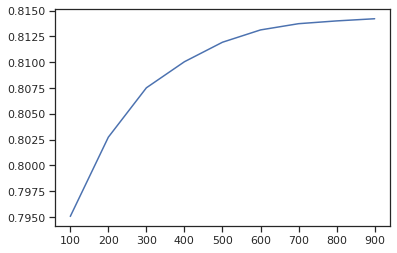

In [ ]:
a = KFoldCV_optimal_Finder_DT(range(100, 1000, 100), X_train, y_train) # max_leaf_node

cross validation을 통해 값에 따른 변화를 관찰해보면 `max_leaf_node`가 높을 수록 즉, 많이 나뉠 수록 더 좋은 성능을 보이는 것을 관찰 할 수 있다. 이는 어쩌면 당연한 것일 수 있다. 대표적으로 ID code problem은 정확도가 굉장히 높지만 새로운 데이터에 대해서는 예측력이 떨어질 수 있다. 하지만 여기에서는 가장 정확도가 높은 900으로 했다. 

Accuracy: 0.8200267022696929
Recall: 0.7926294238081311
Precision: 0.8091967751567632
F1 score: 0.8008274231678487


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


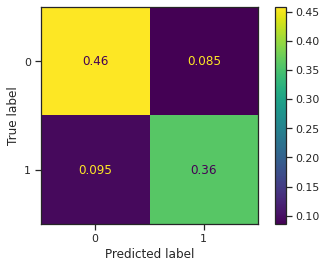

In [ ]:
DT1 = Final_Test_Evaluation(DecisionTreeClassifier(max_leaf_nodes=a),
                             X_train, y_train, X_test, y_test)
plot_confusion_matrix(DT1, X_test, y_test, normalize='all')

만든 Decision tree인 DT!의 정확도는 나쁘지 않다. recall과 precision의 경우도 비슷한 값을 보이기 때문에 별로 문제가 되는 부분은 없다. 

#### DT with feature selection

most optimal parameter value: 700


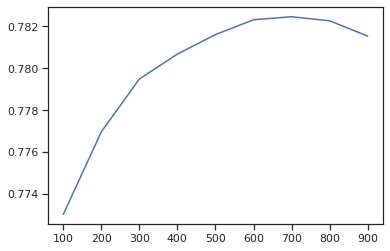

In [ ]:
a = KFoldCV_optimal_Finder_DT(range(100, 1000, 100), X_train_l1, y_train)

Accuracy: 0.796128170894526
Recall: 0.7715706346885054
Precision: 0.7795508274231678
F1 score: 0.775540202851683


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


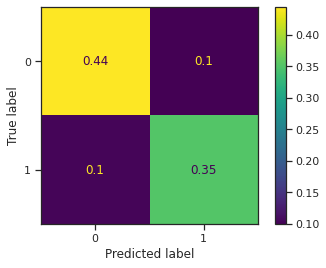

In [ ]:
DT2 = Final_Test_Evaluation(DecisionTreeClassifier(max_leaf_nodes=a),
                             X_train_l1, y_train, X_test_l1, y_test)
plot_confusion_matrix(DT2, X_test_l1, y_test, normalize='all')

보통 feature selection을 하고 나서는 성능이 좋아진다고 알려졌으나 이 경우에는 그렇지 않았다. feature selection을 통해 feature 개수를 줄였다. 보통 성능이 좋아지는 경우는 feature 중에 irrelevant feature나 redundant feature이 섞여있엇 overfitting을 일으키는 경우이다. 이번 사례에서는 일반적인 경우와 다른 결과가 나온 것을 보아, feature에는 overfitting을 일으키는 불필요한 feature가 섞여있지 않은 것으로 보인다.

ㅊ보통 feature selection을 하고 나서는 성능이 좋아진다고 알려졌으나 이 경우에는 그렇지 않았다. feature selection을 통해 feature 개수를 줄였다. 보통 성능이 좋아지는 경우는 feature 중에 irrelevant feature나 redundant feature이 섞여있엇 overfitting을 일으키는 경우이다. 이번 사례에서는 일반적인 경우와 다른 결과가 나온 것을 보아, feature에는 overfitting을 일으키는 불필요한 feature가 섞여있지 않은 것으로 보인다.

다른 평가치를 봤을 때에도 accuracy와 비슷한 수준의  값을 보여준 것을 봤을 때 모델의 정확도가 엄청 높지는 않지만 baseline인 0.55보다는 높은 괜찮은 것으로 보인다. 

### ML algorithm 2 : Perceptron


#### Perceptron without feature selection

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

most optimal parameter value: 1


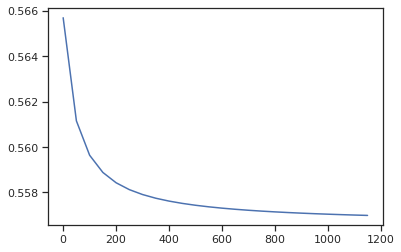

In [ ]:
a = KFoldCV_optimal_Finder_P(range(1, 1200, 50), X_train, y_train)

위 그래프를 보면 iteration 값이 커질 수록 cross valdilation으로 평가한 정확도는 점점 낮아지는 것을 관찰할 수 있다. 이러한 결과에 따라 `max_iter=1`로 parameter를 설정하여 모델을 만들었다. 그런데 `max_iter`의 의미를 생각해보았을 때 최대 epoch의 횟수를 제한했을 때 정확도가 더 좋았다는 것은 perceptron이 데이터 학습을 통해 모델을 만들어 갈 수록 정답을 못맞춘다는 의미이다. perceptron은 linear model이기 때문에 이는 데이터의 class 분포가 non-linear하다는 것을 보여준다고 해석할 수 있다. 

Accuracy: 0.5435246995994659
Recall: 0.0002924831822170225
Precision: 0.5
F1 score: 0.0005846243788365976



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


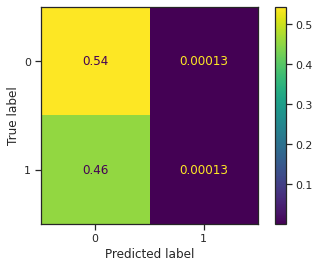

In [ ]:
per1 = Final_Test_Evaluation(Perceptron(max_iter=a, random_state=42),
                             X_train, y_train, X_test, y_test)
print()
plot_confusion_matrix(per1, X_test, y_test, normalize='all')

일단은 이렇게해서 만들어진 모델 __per1__은 baseline인 zero R의 0.55도 넘지 못하는 정도의 안 좋은 모델이다. 이러한 결과가 나온 것은 여러가지 요인이 존재한다. 일단 `max_iter=1`이기 때문에 한 번의 epoch만 가지고 모델을 생성했다는 점이 문제가 될 수 있다. 그래서 과연 parameter의 문제로 인해 문제가 만들어졌는지 확인하기 위해 다음과 같이 __per_defalut__ 모델을 만들어 test를 해보았다. 



In [ ]:
#perceptron default 
per_default = Perceptron(random_state=42)
per_default.fit(X_train, y_train)
y_pred_per_d = per_default.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_per_d))
print("Recall", recall_score(y_test, y_pred_per_d))
print("Precision", precision_score(y_test, y_pred_per_d))
print("F1 score", f1_score(y_test, y_pred_per_d))

Accuracy: 0.5686248331108145
Recall 0.07633811055864288
Precision 0.781437125748503
F1 score 0.13908872901678657


확인해보았을때 accuracy는 __per1__에 비해서도 baseline보다도 좋은 것을 볼 수 있다. 하지만 baseline을 근소하게 넘은 accuracy이기 때문에 모델 parameter 최적화 과정에서 생긴 문제는 아닌 것으로 보인다. 

 두 번째 눈여겨 볼 점은 데이터의 non-linearity이다. 앞서 증가하는 `max_iter`값에 반비례하는 정확도를 보고 데이터의 non-linearity를 추정했다. 그런데 perceptron은 linear model이기 때문에 non-linear data에 대해서는 분류 능력이 매우 떨어진다. 따라서 이렇게 성능이 떨어지는 모델이 만들어진 주요한 이유는 data의 non-linearity 때문이라고 추측할 수 있다.

#### Perceptron with feature selection

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

most optimal parameter value: 1


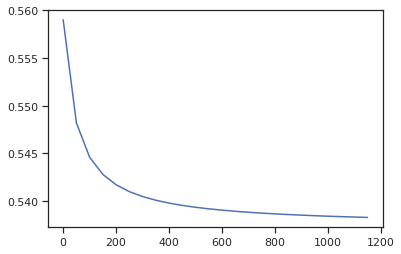

In [ ]:
a = KFoldCV_optimal_Finder_P(range(1, 1200, 50), X_train_l1, y_train)

Accuracy: 0.5435246995994659
Recall: 0.0002924831822170225
Precision: 0.5
F1 score: 0.0005846243788365976



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


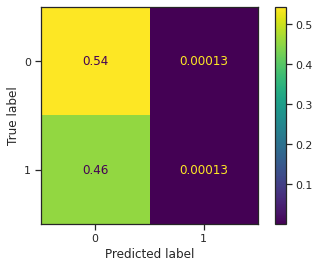

In [ ]:
per2 = Final_Test_Evaluation(Perceptron(max_iter=a, random_state=42),
                             X_train_l1, y_train, X_test_l1, y_test)
print()
plot_confusion_matrix(per2, X_test_l1, y_test, normalize='all')

앞서 decision tree의 __DT1__, __DT2__를 통해 __EEG eye data__에서는 feature selection을 통한 성능향상이 나타나지 않는다고 논했는데, 위 결과를 통해 perceptron의 경우에도 일관된 결과를 보여준다고 할 수 있다.

### ML algorithm 3: Multi-Layered Perceptron(MLP)



#### MLP cross validation do not show difference with `learning_rate` parameter

MLP의 parameter 중 learning rate을 바꾸는 방식을 바꿨을 때 눈을 뜨고 감았는지에 대한 분류능력이 얼마나 달라지는지 확인하기 위해 다음과 같이 cross validation을 진행하였다.

In [ ]:
score = {}

skf = StratifiedKFold(n_splits=10)
val_accuracy = np.array([])

for LR in ['constant', 'invscaling', 'adaptive']:
  MLP = MLPClassifier(learning_rate = LR, random_state=42)
  for train_index, val_index in skf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    MLP.fit(X_train_cv, y_train_cv)
    val_accuracy = np.append(val_accuracy, MLP.score(X_val_cv, y_val_cv))
  score[LR] = val_accuracy.mean()


for key, value in score.items():
    print(key, ' : ', value)

constant  :  0.5260347129506008
invscaling  :  0.526034712950601
adaptive  :  0.526034712950601


그 결과 learning rate이 변하는 방식과 예측력은 여기에서는 큰 연관성이 없는 것이 동일한 성능을 보여주었다. 따라서 `learning_rate`은 parameter의 최적화를 위해 별다른 조작이 필요하지는 않다고 정리할 수 있다.

#### MLP without feature selection
MLP에서 1-2층의 hidden layer를 통해 non-linear model을 만들 수 있는 만큼 hidden layer를 잘 설계하는 것이 중요하다. 하지만 MLP와 마찬가지로 Neural network를 가지고 model을 만들 때는 hidden input layer와 output layer는 잘 보이기 때문에 설계하는 게 쉬운 반면, hidden layer는 매우 어렵다. 그래서 여기에서 `hidden_layer_sizes`의 값을 점점 늘려 가며 가장 좋은 성능을 보여주는 parameter 값을 찾으려 했다.

most optimal parameter value: 320


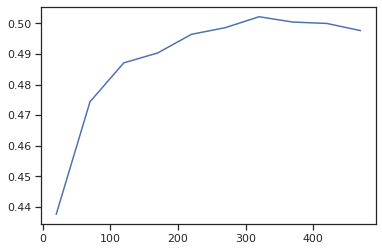

In [ ]:
a = KFoldCV_optimal_Finder_MLP(range(20, 500, 50), X_train, y_train)

그 결과 320에서 가장 좋은 성능을 보여주었다.그래서 이 값을 가지고 MLP 모델을 만들어 성능을 평가했다. 앞서 perceptron에서 주어진 데이터가 non-linearity를 가지고 있다고 했기 때문에 MLP에서는 좀 더 나은 성적을 보이지 않을까하고 예측할 수 있다.

Accuracy: 0.4563417890520694
Recall: 0.999707516817783
Precision: 0.45640272399519294
F1 score: 0.6266960029336267



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


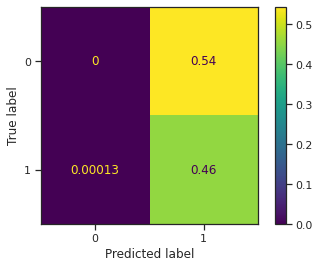

In [ ]:
MLP1 = Final_Test_Evaluation(MLPClassifier(hidden_layer_sizes=a, random_state=42),
                             X_train, y_train, X_test, y_test)
print()
plot_confusion_matrix(MLP1, X_test, y_test, normalize='all')

하지만 위의 결과를 보았을 때, 예상했던 결과와는 사뭇다른 모습을 볼 수 있다. 일단 perceptron으로 만든 모델보다도 더 떨어지고 심지어 둘 중 하나를 random으로 골랐을 때 나올 확률(0.5)보다도 낮을 정확도를 보여주었다. 높은 recall의 경우 마치 zero rule로 1을 고르는 모델을 만드는 것과 같은 모델을 만들었기 때문에 가능한 수치이다. 이러한 결과가 나온 것은 MLP의 layer 개수가 nonlinear data를 정확하게 분류하기에는 부족했던 것일 수 있다. cross validation을 했을 때의 정확도와 test set을 가지고 했을 때의 정확도가 차이가 나는 이유는 어쩌면 과도하게 많은 hidden layer 때문일 수 있다. layer unit이 증가함에 따라서 복잡도가 증가하고 overfitting이 발생할 가능성이 높아질 것이라 생각된다. 

#### MLP with feature selection

most optimal parameter value: 70


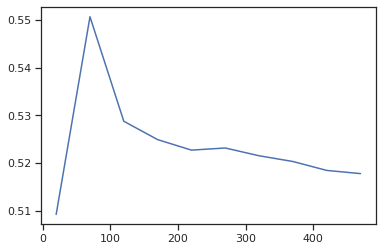

In [ ]:
a = KFoldCV_optimal_Finder_MLP(range(20, 500, 50), X_train_l1, y_train)

Accuracy: 0.5264352469959946
Recall: 0.7247733255337818
Precision: 0.487411487018096
F1 score: 0.5828531106668234



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


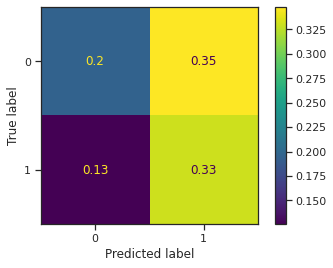

In [ ]:
MLP2 = Final_Test_Evaluation(MLPClassifier(hidden_layer_sizes=a, random_state=42),
                             X_train_l1, y_train_n, X_test_l1, y_test_n)
print()
plot_confusion_matrix(MLP2, X_test_l1, y_test, normalize='all')

앞서의 모델들은 feature selection을 한 것과 그렇지 않은 것 사이의 차이가 크지 않았다. 하지만 MLP에서는 feature selection을 한 경우에 명확하게 더 좋은 성능을 보여주었다. 물론 baseline보다 낮은 성능을 보여주기 때문에 좋은 모델이라고 볼 수 없지만 feature selection이 더 좋은 성능을 가져다 준다는 일반적인 사실에 부합하는 결과라고 볼 수 있다. 이를 역으로 생각해보면 MLP를 이용할 때는 불필요한 feature의 제거가 성능 향상에 더 큰 영향을 준다고 볼 수도 있을 것이다. 

한편 이 성능 향상에 대해서 hidden layer unit의 개수를 가지고 생각해 볼 수 있다. feature selection을 한 후에 cross validation을 하여 각 parameter value에서의 성능을 봤을 때 위 그림을 보면 70이라는 값에서 급격하게 증가한 것을 볼 수 있다. 일단 70은 320보다 작은 수이기 때문에 복잡도의 증가가 줄어든다. 그리고 급격하게 증가했다는 점에 주목할 수 있다. feature selection을 하여 classification에 좀 더 설명력이 높은 feature이 있는 환경에서는 알맞은 hidden unit의 개수가 존재할 것이라고 생각해 볼 수 있다. 위 그래프에서 보여준 급격한 상승 그리고 그 수를 지났을 때 보여주는 하락은 이런 부분을 보여준다고 해석할 수도 있다.

### ML algorithm 4: Random Forest(RF)

#### RF without feature selection

most optimal parameter value: 1


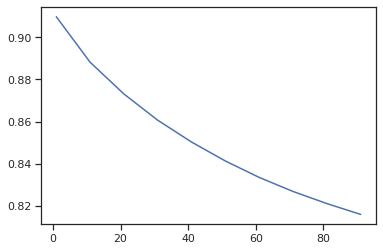

In [ ]:
a = KFoldCV_optimal_Finder_RF(range(1,101, 10), X_train, y_train)

branch를 나누기 위한 최소한의 sample 개수를 지정하는  parameter인 `min_samples_leaf`를 점차 늘려가며 cross validation을 했을 때 결과적으로는 원래의 default 값인 1이 가장 좋은 성능을 보여주었다. `min_samples_leaf`가 banch를 나누는 하방선이 되다보니 이 선이 높아지면 높아질 수록 정확도가 1이 아닌 leaf가 많이 생겨날 것이다. 따라서 이런 추론을 통해 위의 그래프를 해석할 수 있다.

Accuracy: 0.9120160213618158
Recall: 0.8713073998245101
Precision: 0.9315196998123827
F1 score: 0.9004080398972344



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


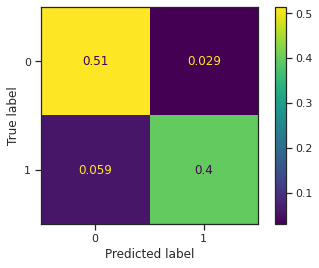

In [ ]:
RF1 = Final_Test_Evaluation(RandomForestClassifier(min_samples_leaf=a, random_state=42),
                             X_train, y_train, X_test, y_test)
print()
plot_confusion_matrix(RF1, X_test, y_test, normalize='all')

여태껏 만들었던 모델 중에 가장 정확도가 높은 모델로 0.91의 accuracy를 보여준다. recall과 precision도 각각 0.87, 0.93으로 상당히 좋아 class imbalance가 심하지 않았던 앞의 baseline 부분과 일관된다. 


#### RF with feature selection

most optimal parameter value: 1


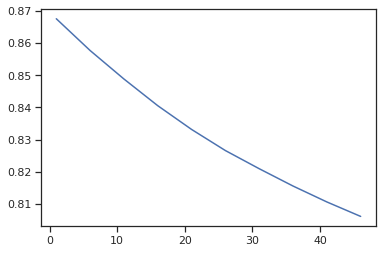

In [ ]:
a = KFoldCV_optimal_Finder_RF(range(1,50, 5),X_train_l1, y_train)

feature selection 없이 진행한 모델과 마찬가지로 `min_samples_leaf=1`일 때 가장 좋은 정확도를 보여주었다.

Accuracy: 0.8700934579439252
Recall: 0.8078385492834163
Precision: 0.8973359324236517
F1 score: 0.8502385716484532



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


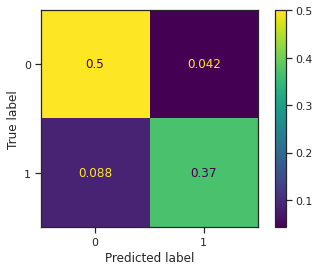

In [ ]:
RF2 = Final_Test_Evaluation(RandomForestClassifier(min_samples_leaf=a, random_state=42),
                             X_train_l1, y_train, X_test_l1, y_test)
print()
plot_confusion_matrix(RF2, X_test_l1, y_test, normalize='all')

feature selection을 한 data를 가지고 학습과 test를 진행했을 때 앞의 Decision tree, perceptron과 마찬가지로 feature selection을 하지 않은 모델보다 낮은 성능을 보여주었다. 이렇게 일관된 결과를 보면 모든 feature가 classification에 영향을 미칠 수 있는 경우에는 feature selection이 오히려 underfitting을 유발하여 더 낮은 성능을 보여주는 것일 지도 모른다는 가설을 생각해볼 수 있다.

# Discussion

EEG data의 signal이 noise에 의한 것인지 아니면 뉴런으로부터 온 signal인지 파악하는 것은 중요하며 noise에 상당 부분은 눈을 깜빡이는 것이 원인이 된다. 눈을 깜빡이는 것은 자연스러운 현상이고 정상적인 실험을 위해 막기 힘들기 때문에 이러한 노이즈 발생을 파악하고 알맞은 처리를 하는 것이 중요하다. 

## Random Forest without feature selection is appropriate to EEG eye detection
이 보고서에서는 decision tree, perceptron, MLP, Random Forest 4가지 알고리즘을 가지고 모델을 만들었고 feature selelction의 유무와 각 알고리즘의 parameter에 따라 accuracy, recall, precision, F1 measure 등의 평가치가 어떻게 바뀌는지 서로 비교하였다. 결과적으로 가장 높은 accuracy(0.91)은 random forest default model이 보여주었다. 

random forest가 다른 모델에 비해 더 좋은 성능을 보여줄 수 있었던 것은 Decision tree가 기본적으로 non-linear data에 대해서도 classification 능력을 가지고 있기 때문이다. 앞서 만들어졌던 Decision tree model의 경우 다른 알고리즘으로 만든 모델보다 월등한 성능을 보여주었다는 점이 이를 뒷받침할 수 있다. 게다가 Random forest에서는 variance를 가지는 Decision tree 여러개의 투표를 통해 만들어진 모델이라는 점도 원인 중 하나로 볼 수 있다. Decision tree의 단점은 각진 decision boundary인데, 이를 여러 decision tree 의 투표를 통해서 decision boundary를 부드럽게 하여 해결한다. 여기에서 사용하는 decision tree의 variance는 instance를 나누는 feature을 선택할 때 약간의 random적 요소를 넣어 만들게 된다. 이런 부분은 Random forest가 좋은 성능을 보이는 세번째 요소로 볼 수 있는데, 새로운 데이터를 분류하기 위해서는 general decision boundary가 필요하다. 이런 점으로 미루어 random property가 data에서의 overfitting을 막고 나아가 general decision boundary를 만드는 데 기여를 할지도 모른다. 

## Next Model Producing
0.91이 상당히 높은 정확도의 모델이지만 더욱 정확도를 높이기 위해서 필요한 점은 무엇일까? 첫 번째는 일반적인 decision boundary로 분류할 수 없는 outlier를 제거하는 것이다. 이 보고서에서는 data instance 분포에서 나타났던 outlier들을 제거하지 않고 있는 그대로의 data를 활용하였다. 만약 모델에서 오차를 일으키는데 outlier가 영향을 미친다면 data preprocessing 과정에서 outlier를 제거하는 과정을 포함시킨 방법을 통해 더욱 정확도를 올릴 수 있을 것이다. 두 번째는 dimension reduction을 통해 새로운 feature space에서 classification을 진행하는 것이다. 이 보고서에서는 MLP를 제외하고 feature space를 변형시키는 방법을 이용하지 않았다. 비록 MLP가 좋은 성능을 보여주지는 못했지만 layer가 부족했던 것일 수 있다. 따라서 PCA를 통해 feature extraction을 하고 classification을 진행한다거나, SVM과 같은 알고리즘을 이용하는 것도 좋을 것 같다. 